In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
pysh.utils.figstyle(rel_width=0.1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

We start by setting the truncation degree for the calculations

In [37]:
L = 256*2

Next we read in the initial sea level, $SL$, and ice thickness, $I$, from a data file. These variables are stored on a real Gauss-Legendre grid. They can be plotted showing coastlines using SL.geo_plot() whose second argument selects the colourmap used.

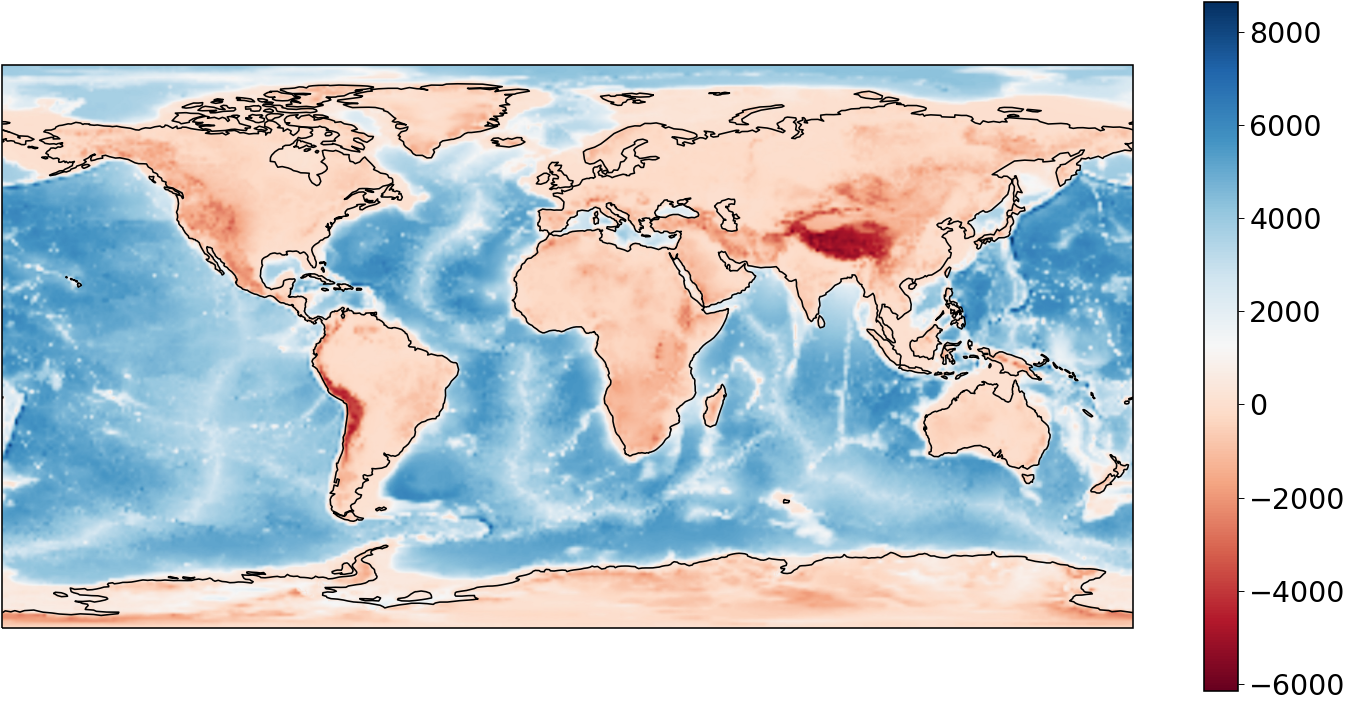

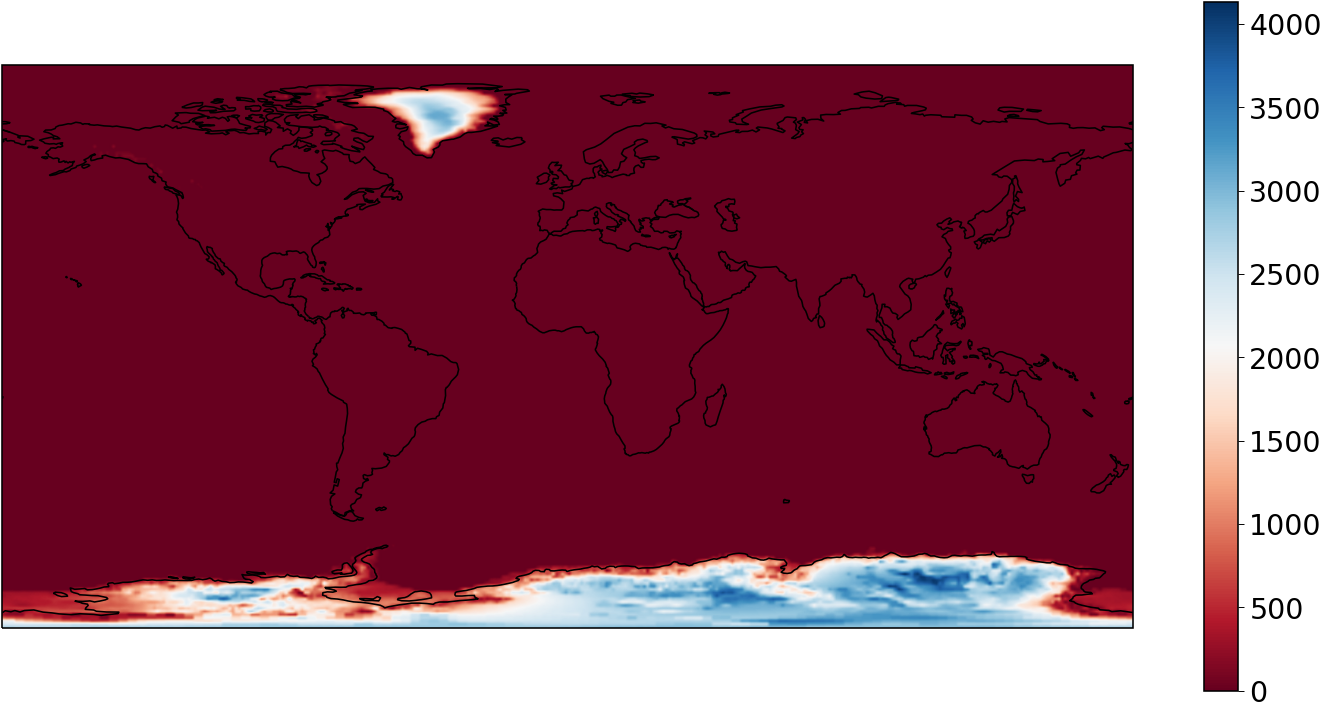

In [38]:
sl0,ice0 = SL.get_sl_ice_data(L)
SL.geo_plot(sl0,'RdBu')
SL.geo_plot(ice0,'RdBu')

From the sea level and ice, we can compute the ocean area. Note that the ocean function is defined to equal one where there is to equal one where water is present and zero elsewhere. Based on a simple isostatic balance between the water and ice, we have
\begin{equation}
C(\theta,\varphi) = \left\{
\begin{array}{cc}
1 & \rho_{w} SL(\theta,\varphi) \ge \rho_{i} I(\theta,\varphi) \\
0 & \rho_{w} SL(\theta,\varphi) < \rho_{i} I(\theta,\varphi) 
\end{array}
\right.
\end{equation}
The ocean area is then defined as
\begin{equation}
A = \int_{\partial M} C\, \mathrm{d} S.
\end{equation}


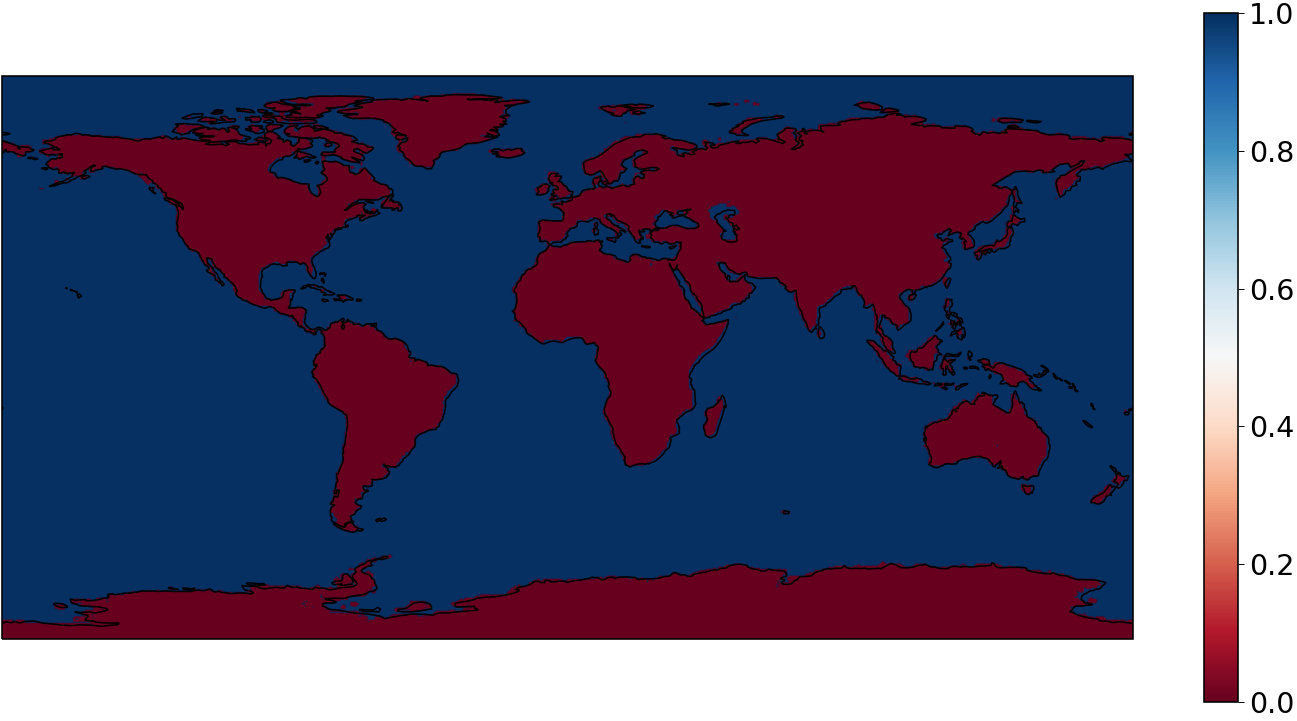

fraction of surface which is ocean =  0.7126907883018665


In [39]:
C = SL.ocean_function(sl0,ice0)
SL.geo_plot(C,'RdBu')
# compute the surface area of the Earth and print fraction that is oceans
A = SL.surface_integral(C)
A_earth = 4*pi*SL.b**2
print('fraction of surface which is ocean = ',A/A_earth)

We now set the ice to be melted, taking as an example a reduction in the height of the Greenland ice sheet by 1%. This can be done as follows:


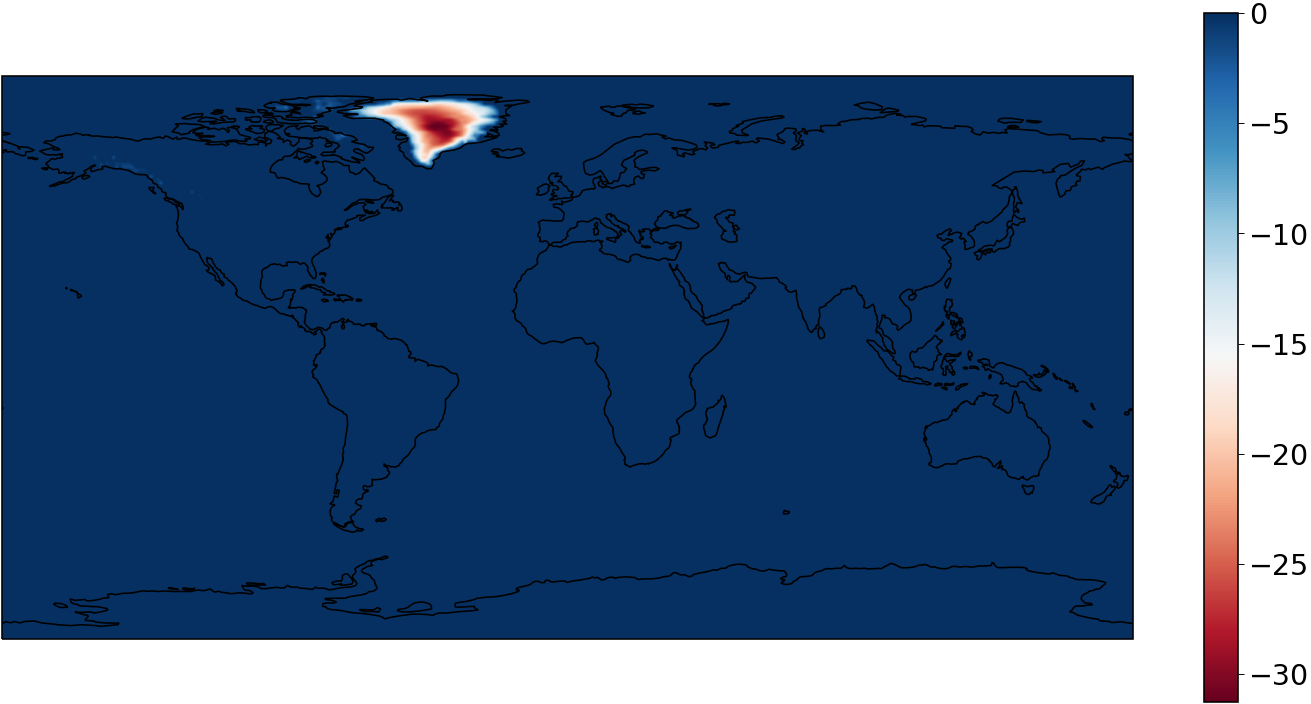

In [40]:
ice = -0.01*SL.zero_southern_hemisphere(ice0)
SL.geo_plot(ice,'RdBu')

Having now defined the problem to be solved, we can solve the sea level equation by calling the following function. Note that it returns perturbations to (at the chosen trunction degree) the sea level change, $SL$, the vertical displacement, $u$, the gravitational potential, $\phi$, and the centrifugal potential, $\psi$ (the latter two plotted as the equivalent change in sea level by scaling by $-1/g$).

iteration =  1 relative change =  18.13888215777572
iteration =  2 relative change =  0.3401512196967513
iteration =  3 relative change =  0.03944278205349999
iteration =  4 relative change =  0.0060180463813421636
iteration =  5 relative change =  0.0010453927140011165
iteration =  6 relative change =  0.0001951916736112586


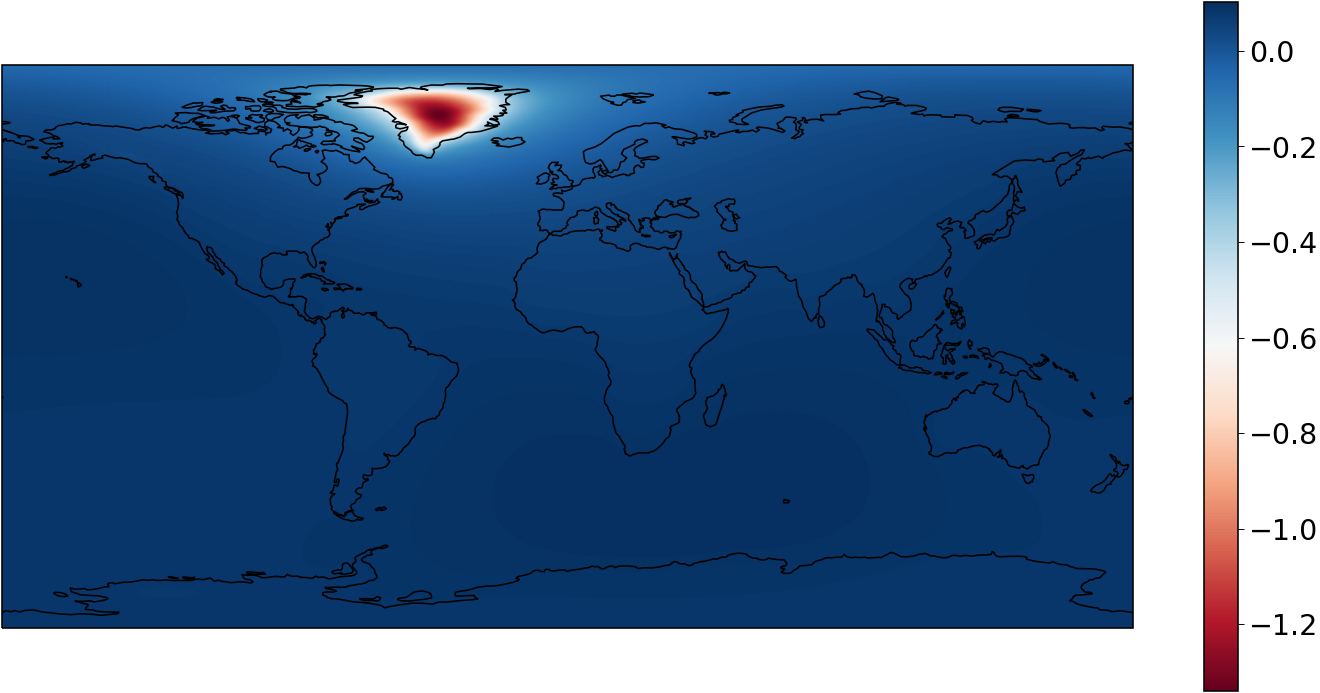

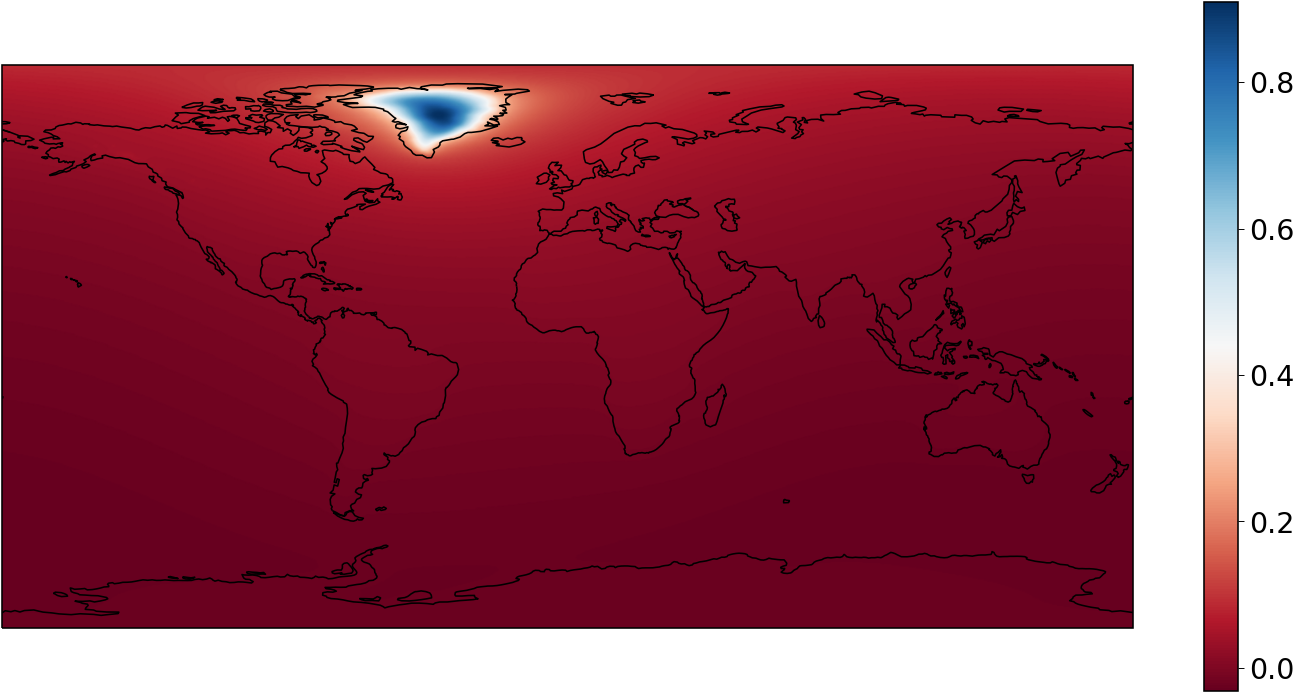

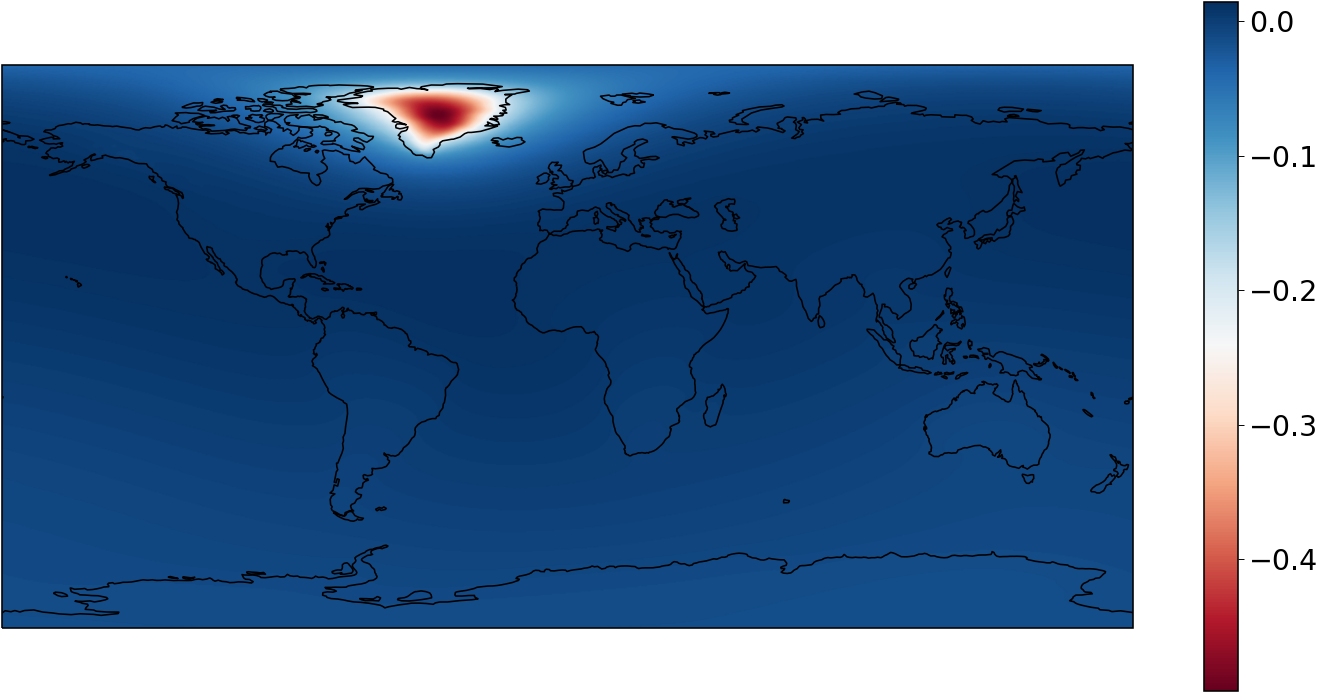

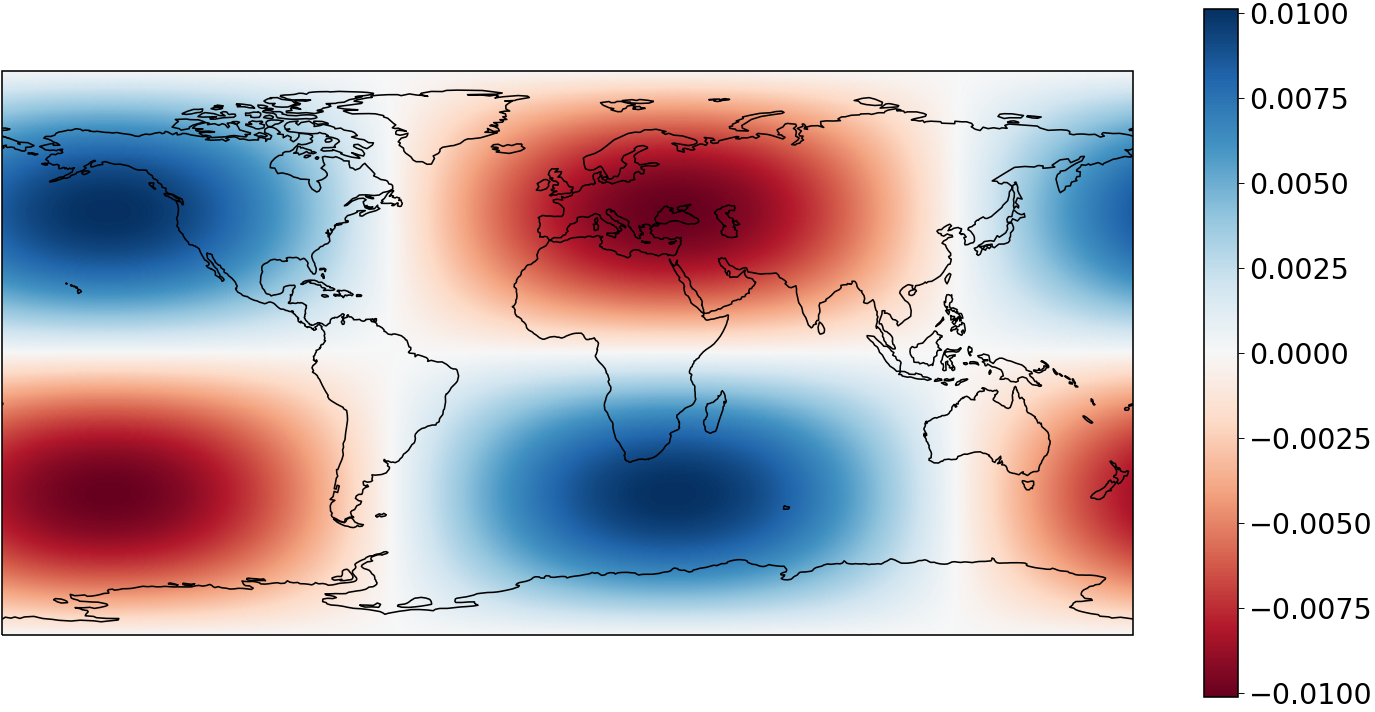

In [41]:
sl,u,phi,psi =  SL.fingerprint(C,ice)
SL.geo_plot(sl,'RdBu')
SL.geo_plot(u,'RdBu')
SL.geo_plot((-1./SL.g)*phi,'RdBu')
SL.geo_plot((-1./SL.g)*psi,'RdBu')